# All fingers Primary Model Pipeline

In [1]:
import collections
import pandas as pd
import numpy as np
import time
import os
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

In [2]:
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [3]:
tf.__version__

'1.13.1'

### Load Datasets and Clean
In this configuration the relevant data set should be loaded from the same folder as the notebook

In [4]:
df = pd.read_csv('/nfs/2018/j/jcruz-y-/neurotron_datasets/joined/joined_data_106979_24-Oct-19_17:31_jose_all_1.csv')

The data consists of timestamps from the two hardware devices and a diff between them. When the two hardware data streams were stitched together an effor was made to minimize this diff, but the driver configuration did not easily permit eliminating it. This information is included to understand the accuracy of the data, but will not be used during the training.

The time data is followed by the 8 channels from the Myo, this data will be used as input features.

This is followed by the 63 positional points from the Leap cameras. These will be used as labels.

In [5]:
df.head()

,Leap timestamp,timestamp diff,emg timestamp,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Wrist x,Wrist y,Wrist z,Thumb Proximal x,Thumb Proximal y,Thumb Proximal z,Thumb Intermediate x,Thumb Intermediate y,Thumb Intermediate z,Thumb Distal x,Thumb Distal y,Thumb Distal z,Thumb Tip x,Thumb Tip y,Thumb Tip z,Index Proximal x,Index Proximal y,Index Proximal z,Index Intermediate x,Index Intermediate y,Index Intermediate z,Index Distal x,Index Distal y,Index Distal z,Index Tip x,Index Tip y,Index Tip z,Middle Proximal x,Middle Proximal y,Middle Proximal z,Middle Intermediate x,Middle Intermediate y,Middle Intermediate z,Middle Distal x,Middle Distal y,Middle Distal z,Middle Tip x,Middle Tip y,Middle Tip z,Ring Proximal x,Ring Proximal y,Ring Proximal z,Ring Intermediate x,Ring Intermediate y,Ring Intermediate z,Ring Distal x,Ring Distal y,Ring Distal z,Ring Tip x,Ring Tip y,Ring Tip z,Pinky Proximal x,Pinky Proximal y,Pinky Proximal z,Pinky Intermediate x,Pinky Intermediate y,Pinky Intermediate z,Pinky Distal x,Pinky Distal y,Pinky Distal z,Pinky Tip x,Pinky Tip y,Pinky Tip z
0,1.571891e+09,0.006226,1.571891e+09,50.0,250.0,396.0,89.0,53.0,43.0,31.0,61.0,9.262085,-9.118690,47.617905,-18.114399,-8.678528,51.673462,-46.709621,-12.567474,17.094170,-69.877258,-11.163055,-3.096992,-85.138763,-10.990265,-17.690151,-20.603283,15.033867,-19.298096,-18.594982,29.675285,-55.134228,-23.628544,21.952751,-74.898529,-29.280987,9.089638,-81.241966,-1.600807,9.199806,-21.184177,9.602978,22.597313,-61.013245,5.366776,12.613152,-84.265617,-2.429310,-1.073235,-90.542023,16.659401,0.454193,-17.607121,31.992260,15.967636,-51.509766,30.006121,9.053932,-75.447060,22.099865,-3.387665,-83.625824,31.320591,-11.242180,-12.971455,48.320904,0.762253,-37.152554,49.054413,-1.940414,-54.576313,42.004250,-10.960121,-65.103134
1,1.571891e+09,-0.029152,1.571891e+09,50.0,286.0,368.0,74.0,51.0,29.0,23.0,42.0,6.786233,-11.333852,47.534789,-20.769446,-11.812599,49.990927,-48.818829,-12.573416,14.808353,-71.526649,-9.472275,-5.685904,-86.040143,-8.497499,-20.978106,-19.892583,15.473871,-19.684725,-16.363919,31.977931,-54.562784,-20.061439,25.205292,-74.945980,-24.964155,12.585976,-82.297033,-0.656441,10.240284,-20.741277,12.169991,25.430847,-59.404511,9.774177,16.861857,-83.445555,3.000662,3.609998,-91.510464,17.612489,1.798022,-16.543760,34.630843,19.197273,-48.656146,34.708936,13.781877,-73.032392,28.021311,1.851053,-82.843496,32.317179,-9.737174,-11.650706,50.569850,3.507205,-34.192403,52.642263,1.569894,-51.594506,46.731619,-7.074512,-63.067226
2,1.571891e+09,0.001225,1.571891e+09,48.0,270.0,347.0,69.0,50.0,29.0,22.0,37.0,5.317806,-12.499672,47.453987,-22.304150,-13.473961,48.934364,-50.567093,-11.620216,13.915695,-73.125786,-7.157860,-6.519272,-87.022034,-5.696548,-22.351597,-19.449600,15.688126,-19.963085,-15.181034,33.082428,-54.341133,-18.064960,27.075287,-75.106461,-22.477337,14.810486,-83.337776,-0.101135,10.783897,-20.485744,13.475960,26.486450,-58.701767,12.304794,18.931656,-83.193710,6.364304,6.209526,-92.698830,18.149715,2.515739,-15.874870,36.093548,20.546936,-47.148628,37.534588,16.020477,-71.687836,31.792110,4.564583,-82.641403,32.863037,-8.918983,-10.774841,52.029774,4.644127,-32.373928,55.188416,3.101257,-49.667633,50.315052,-5.215370,-61.872467
3,1.571891e+09,0.009088,1.571891e+09,49.0,245.0,326.0,66.0,39.0,28.0,23.0,36.0,5.141285,-12.493469,47.475067,-22.483795,-13.559532,48.828407,-50.828781,-11.390457,13.894257,-73.361900,-6.804001,-6.541451,-87.106232,-5.372879,-22.508564,-19.409599,15.628494,-20.048607,-15.110043,33.002945,-54.432831,-17.841034,27.203735,-75.277794,-22.137730,15.102798,-83.807457,-0.042805,10.788460,-20.483543,13.552137,26.346481,-58.752304,12.602261,18.943726,-83.300186,6.865059,6.356377,-93.104897,18.213963,2.579636,-15.790806,36.240501,20.540024,-47.057739,37.922184,16.111511,-71.599510,32.396820,4.750542,-82.761627,32.941494,-8.807564,-10.625877,52.218910,4.702339,-32.159714,55.573746,3.183128,-49.418533,50.933563,-5.084938,-61.746620
4,1

In [6]:
df = df.drop(labels=["Leap timestamp", "timestamp diff", "emg timestamp"], axis=1)

In [7]:
df.describe()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Wrist x,Wrist y,Wrist z,Thumb Proximal x,Thumb Proximal y,Thumb Proximal z,Thumb Intermediate x,Thumb Intermediate y,Thumb Intermediate z,Thumb Distal x,Thumb Distal y,Thumb Distal z,Thumb Tip x,Thumb Tip y,Thumb Tip z,Index Proximal x,Index Proximal y,Index Proximal z,Index Intermediate x,Index Intermediate y,Index Intermediate z,Index Distal x,Index Distal y,Index Distal z,Index Tip x,Index Tip y,Index Tip z,Middle Proximal x,Middle Proximal y,Middle Proximal z,Middle Intermediate x,Middle Intermediate y,Middle Intermediate z,Middle Distal x,Middle Distal y,Middle Distal z,Middle Tip x,Middle Tip y,Middle Tip z,Ring Proximal x,Ring Proximal y,Ring Proximal z,Ring Intermediate x,Ring Intermediate y,Ring Intermediate z,Ring Distal x,Ring Distal y,Ring Distal z,Ring Tip x,Ring Tip y,Ring Tip z,Pinky Proximal x,Pinky Proximal y,Pinky Proximal z,Pinky Intermediate x,Pinky Intermediate y,Pinky Intermediate z,Pinky Distal x,Pinky Distal y,Pinky Distal z,Pinky Tip x,Pinky Tip y,Pinky Tip z
count,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000,106979.000000
mean,107.959076,277.776554,293.447060,112.697202,55.729031,72.685406,82.720188,67.966208,-1.519532,-9.021946,44.597009,-24.352507,-18.957473,39.809937,-35.202575,-26.591242,2.103636,-40.789788,-32.012339,-22.847791,-44.154327,-35.382372,-37.740631,-16.995893,7.373415,-23.683015,-14.404202,3.981787,-54.751712,-13.055133,-3.578775,-67.611467,-12.313513,-10.208400,-73.972310,0.712549,9.388218,-19.306369,9.581468,4.679483,-53.065222,12.692946,-4.684326,-67.946889,13.756485,-12.317275,-74.908446,17.529791,8.095233,-10.276684,25.648988,-0.778659,-40.999281,27.275005,-12.593958,-54.669632,27.006531,-21.898478,-60.856092,32.352225,2.837640,-1.285509,41.970822,-4.485664,-24.370822,43.496761,-12.840841,-34.176921,42.845118,-21.385414,-40.369203
std,94.478903,183.819378,181.553457,80.348375,68.751875,110.614351,137.870160,103.867191,18.203014,13.902148,5.902738,17.833762,17.313549,12.854626,10.539880,13.674356,17.937670,20.180079,18.120903,22.667319,30.208039,23.253477,26.870641,9.447936,7.232516,7.711189,22.331166,23.019437,11.387768,28.566881,33.673159,18.030049,32.359781,40.269171,25.337680,8.255159,6.050276,3.587558,22.631948,25.144259,10.117039,30.242326,37.583324,18.901129,34.760672,44.641463,27.063839,5.532313,7.853489,8.013560,18.961775,22.917322,13.537246,27.110144,33.080043,21.107323,32.277698,38.685426,28.408468,4.083498,11.077100,13.504016,14.765910,20.311902,18.142483,21.859076,26.318486,21.132027,28.005897,30.720860,25.151496
min,18.000000,20.000000,22.000000,20.000000,17.000000,16.000000,15.000000,15.000000,-49.460617,-51.661484,-8.476379,-59.220070,-58.296936,-27.315063,-70.195053,-71.954811,-49.751572,-92.561234,-90.297638,-74.886850,-112.754237,-103.504150,-94.854360,-35.338264,-31.792175,-35.444645,-69.852450,-67.396919,-74.289215,-85.011714,-87.236955,-96.546054,-97.884471,-102.978952,-112.462585,-24.145329,-21.980112,-25.657837,-54.249256,-65.532608,-72.724304,-75.109543,-91.424866,-100.599316,-91.211243,-109.174942,-118.985

## Autoencoder
The final pipeline will pass the data into an LSTM and then into an autoencoder to expand features into the 63 point space. This autoencoder will be trained first below:

In [8]:
feature_ar = df.loc[:, 'ch1':'ch8'].values
label_ar = df.loc[:, 'Wrist x':].values

In [9]:
feature_ar.shape

(106979, 8)

In [10]:
label_ar.shape

(106979, 63)

Build the autoencoder structure:

In [11]:
encoding_dim = 9 #dimensionality of 'feature' vector

a_fn = None

# Full autoencoder
input_vec = Input(shape=(63,))
dense_0 = Dense(32, activation=a_fn)(input_vec)
dense_1 = Dense(16, activation=a_fn)(dense_0)
encoded = Dense(encoding_dim, activation=a_fn)(dense_1)
dense_2 = Dense(32, activation=a_fn, name='decoder_0')(encoded)
dense_3 = Dense(16, activation=a_fn, name='decoder_1')(dense_2)
decoded = Dense(63, activation=a_fn, name='decoder_output')(dense_3)

autoencoder = Model(input_vec, decoded)

# Encoder from autoencoder
encoder = Model(input_vec, encoded)

# Decoder from autoencoder layers
decoder_input = Input(shape=(encoding_dim,), name='encoded_input')
decode_0 = autoencoder.layers[-3](decoder_input)
decode_1 = autoencoder.layers[-2](decode_0)
decode_output = autoencoder.layers[-1](decode_1)
decoder = Model(decoder_input, decode_output, name='decoder')

# Train Autoencoder
optimizer = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')
autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 63)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2048      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 153       
_________________________________________________________________
decoder_0 (Dense)            (None, 32)                320       
_________________________________________________________________
decoder_1 (Dense)            (None, 16)                528       
______________________

In [12]:
autoencoder.evaluate(label_ar, label_ar)

106979/106979 [==============================] - 3s 26us/sample - loss: 2945.7349s


2945.7349400705616

From the above evaluation the initial untrained loss is around 2500.
Now train the model:

In [13]:
ret = autoencoder.fit(label_ar, label_ar, batch_size=312, epochs=3, verbose=1, validation_split=0.2)

Train on 85583 samples, validate on 21396 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
85583/85583 [==============================] - 2s 21us/sample - loss: 616.2037 - val_loss: 176.6740
Epoch 2/3
85583/85583 [==============================] - 1s 12us/sample - loss: 115.1357 - val_loss: 110.7994
Epoch 3/3
85583/85583 [==============================] - 1s 13us/sample - loss: 89.1990 - val_loss: 86.4276


Now the encoder - decoder pair will be tested seperately for loss:

In [14]:
encoded_vec = encoder.predict(label_ar)
decoded_vec = decoder.predict(encoded_vec)

#compilation is only to enable evaluation
decoder.compile(optimizer='adam', loss='mse')
decoder.evaluate(encoded_vec, label_ar)

106979/106979 [==============================] - 3s 24us/sample - loss: 79.9229s - loss: 64. -


79.92293664577112

In [15]:
print(encoded_vec.shape)
print(decoded_vec.shape)

(106979, 9)
(106979, 63)


## LSTM
Here the lstm will be trained. The 8 channels of sEMG data will be processed by the LSTM, which will return a vector of 9 complex features. These will then be processed by the autoencoder, trained in the previous section, to create the 63 hand coordinates.

To train the sequential recurrent LSTM the data will be grouped into 'sequences' of 24 steps in time. The LSTM will be trained with many sequence groups.

In [21]:
seq_length = 24

def overlap_samples(seq_length, feats, labels):
    new_l = labels[seq_length - 1:]
    feat_list = [feats[i:i + seq_length] for i in range(feats.shape[0] - seq_length + 1)]
    new_f = np.array(feat_list)
    return new_f, new_l

features, labels = overlap_samples(seq_length, feature_ar, label_ar)
print(features.shape)
print(labels.shape)

(106956, 24, 8)
(106956, 63)


In [22]:
#lstm layers
inputs = Input(shape=(None, 8), name="inputs")
lstm_0 = LSTM(64, return_sequences=True, name="lstm_0")(inputs)
do = Dropout(0.2)(lstm_0)
lstm_1 = LSTM(64, return_sequences=False, name="lstm_1")(do)
do_2 = Dropout(0.2)(lstm_1)
lstm_out = Dense(9, activation=None, name="lstm_out")(do_2)

#decoder layers
decoder_0 = decoder.get_layer("decoder_0")(lstm_out)
decoder_0.trainable = False
decoder_1 = decoder.get_layer("decoder_1")(decoder_0)
decoder_1.trainable = False
decoder_output = decoder.get_layer("decoder_output")(decoder_1)
decoder_output.trainable = False

model = Model(inputs, decoder_output, name="model_v1")
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, None, 8)           0         
_________________________________________________________________
lstm_0 (LSTM)                (None, None, 64)          18688     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
lstm_out (Dense)             (None, 9)                 585       
_________________________________________________________________
decoder_0 (Dense)            (None, 32)                320       
__________

In [23]:
model.evaluate(features, labels, verbose=1)

106956/106956 [==============================] - 29s 274us/sample - loss: 1544.2325


1544.2324921799034

In [24]:
#class_weights = 

In [25]:
history = model.fit(features, labels, batch_size=seq_length, epochs=4, verbose=1, validation_split=0.2)

Train on 85564 samples, validate on 21392 samples
Epoch 1/4
85564/85564 [==============================] - 136s 2ms/sample - loss: 558.6729 - val_loss: 545.2072
Epoch 2/4
85564/85564 [==============================] - 131s 2ms/sample - loss: 392.6791 - val_loss: 502.2254
Epoch 3/4
29928/85564 [=========>....................] - ETA: 1:24 - loss: 371.0232

KeyboardInterrupt: 

### Visualize Model Error

Plot the validation loss over the training epochs:

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])

NameError: name 'history' is not defined

Plotting the errors for each field below shows that the 'y' coordinates for each figure generally have the largest error and the errors growing rapidly approaching the tips of the fingers.

In [34]:
preds = model.predict(features)

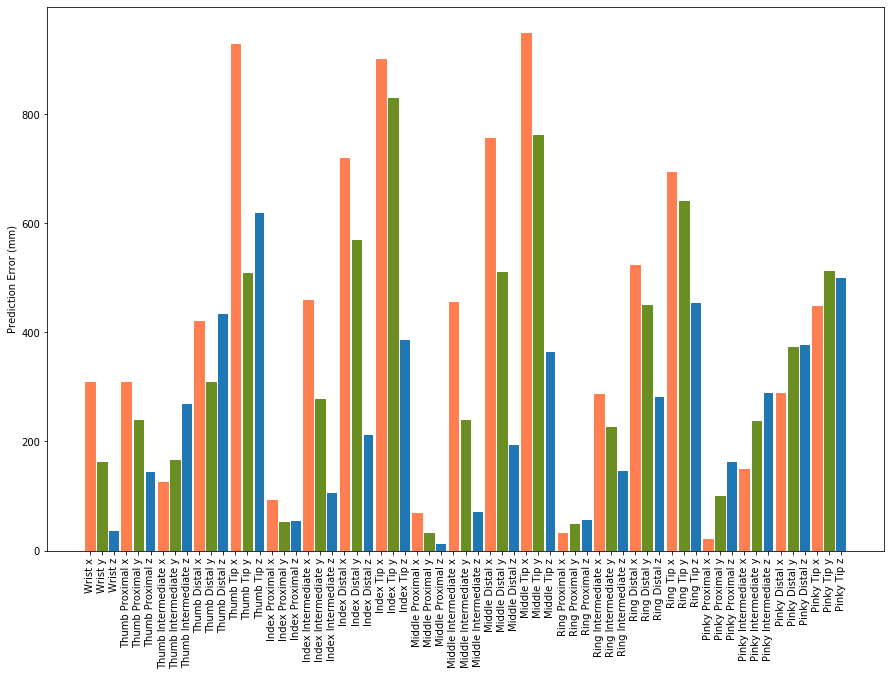

In [35]:
error = labels - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:], avg_error)
for i in range(0,63,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

### Winner?

In [36]:
model_fc = tf.keras.models.Sequential()
model_fc.add(LSTM(256, return_sequences=True, input_shape=(seq_length, 8)))
model_fc.add(Dropout(0.5))
model_fc.add(LSTM(256, return_sequences=True))
model_fc.add(Dropout(0.5))
model_fc.add(LSTM(128))
model_fc.add(BatchNormalization())
model_fc.add(Dense(512, input_dim=128))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.5))
model_fc.add(Dense(512, input_dim=512))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.5))
model_fc.add(Dense(256, input_dim=512))
model_fc.add(Activation('relu'))
model_fc.add(Dropout(0.3))
model_fc.add(Dense(63, input_dim=64))
model_fc.compile(optimizer='Adam', loss='mse')
model_fc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32, 256)           271360    
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 256)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32, 256)           525312    
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 256)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               197120    
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 128)               512       
_________________________________________________________________
dense_7 (Dense)              (None, 512)               66048     
__________

In [37]:
history = model_fc.fit(features, labels, batch_size=seq_le iiingth, epochs=4, verbose=1, validation_split=0.2)

Train on 85558 samples, validate on 21390 samples
Epoch 1/4
85558/85558 [==============================] - 1450s 17ms/sample - loss: 351.6482 - val_loss: 483.9309
Epoch 2/4
85558/85558 [==============================] - 1101s 13ms/sample - loss: 247.3868 - val_loss: 426.7974
Epoch 3/4
 1504/85558 [..............................] - ETA: 27:19 - loss: 226.3581

KeyboardInterrupt: 

In [38]:
model_fc.save('FC_model_jose_all_val_loss_400_1.h5')

## LSTM with Fully Connected Layers
Below is a test using a model with several dense layers after the LSTM layers, instead of using the pretrained autoencoder.

In [27]:
model_fc = tf.keras.models.Sequential()
model_fc.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 8)))
model_fc.add(Dropout(0.2))
model_fc.add(LSTM(64))
model_fc.add(BatchNormalization())
model_fc.add(Dense(100, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.2))
model_fc.add(Dense(64, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(Dropout(0.2))
model_fc.add(Dense(63, input_dim=64))

model_fc.compile(optimizer='Adam', loss='mse')

history = model_fc.fit(features, labels, batch_size=seq_length, epochs=5, verbose=1, validation_split=0.2)

Train on 13160 samples, validate on 3290 samples
Epoch 1/5
13160/13160 [==============================] - 25s 2ms/sample - loss: 446.7564 - val_loss: 101.6531
Epoch 2/5
 6592/13160 [==============>...............] - ETA: 10s - loss: 118.3758

KeyboardInterrupt: 

In [ ]:
model_fc.save('FC_model_jose_all_val_loss_100_1.h5')

### Visual Model Error

In [26]:
preds = model_fc.predict(features)

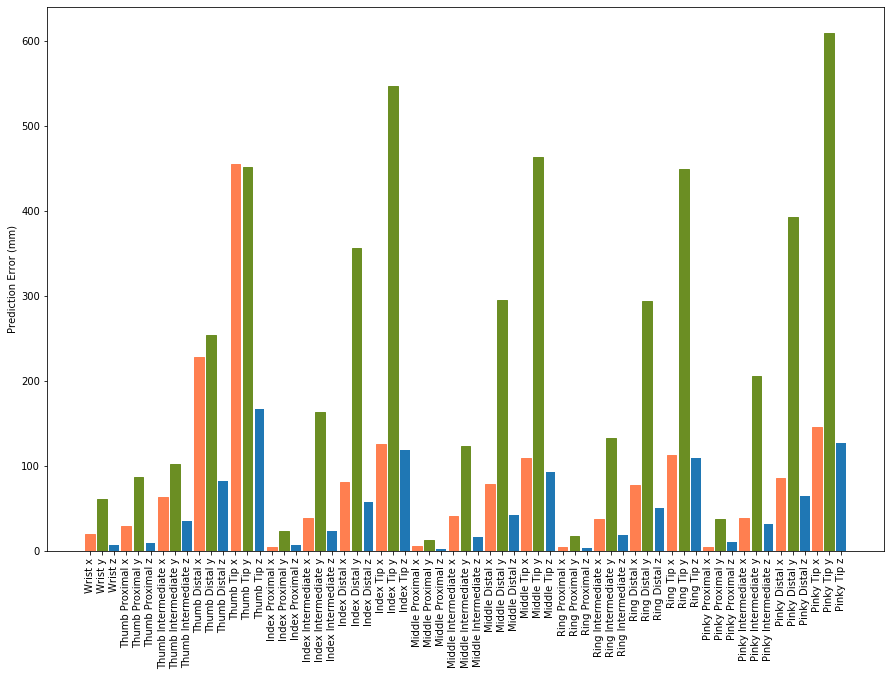

In [27]:
error = labels - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:], avg_error)
for i in range(0,63,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

## Training the Model On Tips Only
In an attempt to improve the accuracy of prediction of the fingertips the above models are modified and trained only using the fingertip position data to understand if this simplification yields an improvement. This is done on both of the architectures tested above.

### Autoencoder Architecture

In [23]:
encoding_dim = 9 #dimensionality of 'feature' vector

a_fn = None

# Full autoencoder
input_vec = Input(shape=(18,))
dense_0 = Dense(32, activation=a_fn)(input_vec)
dense_1 = Dense(16, activation=a_fn)(dense_0)
encoded = Dense(encoding_dim, activation=a_fn)(dense_1)
dense_2 = Dense(32, activation=a_fn, name='decoder_0')(encoded)
dense_3 = Dense(16, activation=a_fn, name='decoder_1')(dense_2)
decoded = Dense(18, activation=a_fn, name='decoder_output')(dense_3)

autoencoder = Model(input_vec, decoded)

# Encoder from autoencoder
encoder = Model(input_vec, encoded)

# Decoder from autoencoder layers
decoder_input = Input(shape=(encoding_dim,), name='encoded_input')
decode_0 = autoencoder.layers[-3](decoder_input)
decode_1 = autoencoder.layers[-2](decode_0)
decode_output = autoencoder.layers[-1](decode_1)
decoder = Model(decoder_input, decode_output, name='decoder')

# Train Autoencoder
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

In [24]:
label_ar_t = label_ar[:,[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]]
label_ar_t.shape

(75055, 18)

In [25]:
ret = autoencoder.fit(label_ar_t, label_ar_t, batch_size=512, epochs=10, verbose=1, validation_split=0.2)

Train on 60044 samples, validate on 15011 samples
Epoch 1/30
60044/60044 [==============================] - 1s 22us/sample - loss: 517.3634 - val_loss: 100.4016
Epoch 2/30
60044/60044 [==============================] - 0s 6us/sample - loss: 97.0044 - val_loss: 58.4423
Epoch 3/30
60044/60044 [==============================] - 0s 5us/sample - loss: 65.6945 - val_loss: 40.5204
Epoch 4/30
60044/60044 [==============================] - 0s 6us/sample - loss: 43.8964 - val_loss: 24.2175
Epoch 5/30
60044/60044 [==============================] - 0s 6us/sample - loss: 26.9545 - val_loss: 16.1705
Epoch 6/30
60044/60044 [==============================] - 0s 5us/sample - loss: 20.5693 - val_loss: 12.6630
Epoch 7/30
60044/60044 [==============================] - 0s 5us/sample - loss: 17.0821 - val_loss: 10.4094
Epoch 8/30
60044/60044 [==============================] - 0s 6us/sample - loss: 14.3927 - val_loss: 8.8769
Epoch 9/30
60044/60044 [==============================] - 0s 6us/sample - loss: 12.2

Create a smaller labels vector with only the tip and wrist x,y,z:

In [26]:
labels_tip = labels[:,[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]]
labels_tip.shape

(75024, 18)

In [27]:
#lstm layers
inputs = Input(shape=(None, 8), name="inputs")
lstm_0 = LSTM(64, return_sequences=True, name="lstm_0")(inputs)
do = Dropout(0.2)(lstm_0)
lstm_1 = LSTM(64, return_sequences=False, name="lstm_1")(do)
lstm_out = Dense(9, activation=None, name="lstm_out")(lstm_1)

#decoder layers
decoder_0 = decoder.get_layer("decoder_0")(lstm_out)
decoder_0.trainable = False
decoder_1 = decoder.get_layer("decoder_1")(decoder_0)
decoder_1.trainable = False
decoder_output = decoder.get_layer("decoder_output")(decoder_1)
decoder_output.trainable = False

model = Model(inputs, decoder_output, name="model_v1")
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00, amsgrad=False)
model.compile(optimizer=optimizer, loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, None, 8)           0         
_________________________________________________________________
lstm_0 (LSTM)                (None, None, 64)          18688     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
lstm_out (Dense)             (None, 9)                 585       
_________________________________________________________________
decoder_0 (Dense)            (None, 32)                320       
_________________________________________________________________
decoder_1 (Dense)            (None, 16)                528       
__________

In [29]:
history = model.fit(features, labels_tip, batch_size=seq_length, epochs=1, verbose=1, validation_split=0.2)

Train on 60019 samples, validate on 15005 samples
60019/60019 [==============================] - 95s 2ms/sample - loss: 139.1871 - val_loss: 121.1162


### Visual Model Error
Model error for the reduced Autoencoder architecture:

In [32]:
preds = model.predict(features)

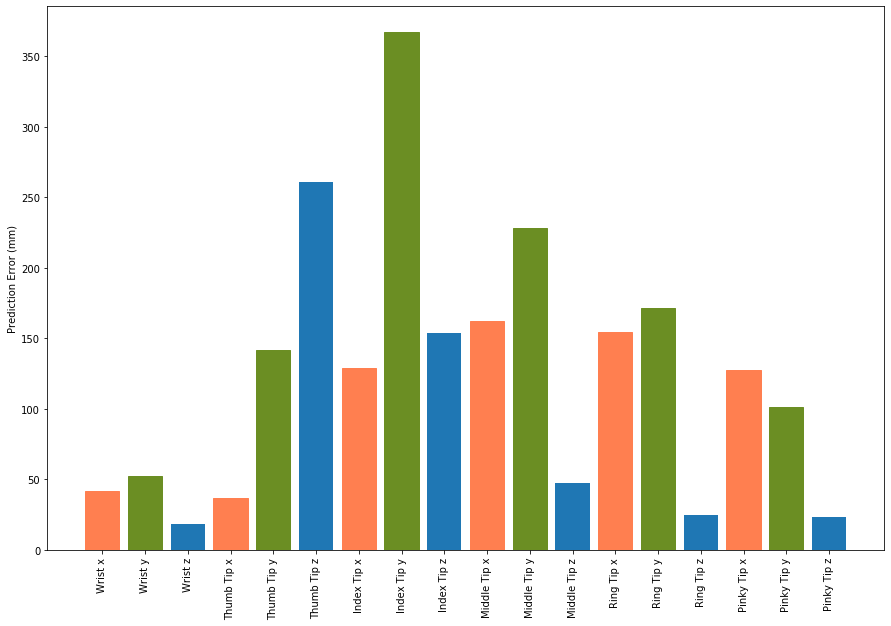

In [31]:
error = labels_tip - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:][[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]], avg_error)
for i in range(0,18,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()

### Tips only with FC Architecture

In [33]:
model_fc = tf.keras.models.Sequential()
model_fc.add(LSTM(64, return_sequences=True, input_shape=(seq_length, 8)))
model_fc.add(Dropout(0.2))
model_fc.add(LSTM(64))
model_fc.add(BatchNormalization())
model_fc.add(Dense(100, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(BatchNormalization())
model_fc.add(Dropout(0.2))
model_fc.add(Dense(64, input_dim=64))
model_fc.add(Activation('relu'))
model_fc.add(Dropout(0.2))
model_fc.add(Dense(18, input_dim=64))

model_fc.compile(optimizer='Adam', loss='mse')

history = model_fc.fit(features, labels_tip, batch_size=seq_length, epochs=9, verbose=1, validation_split=0.2)

Train on 60019 samples, validate on 15005 samples
Epoch 1/9
60019/60019 [==============================] - 105s 2ms/sample - loss: 386.8798 - val_loss: 134.7000
Epoch 2/9
60019/60019 [==============================] - 97s 2ms/sample - loss: 199.4457 - val_loss: 140.3523
Epoch 3/9
60019/60019 [==============================] - 98s 2ms/sample - loss: 169.1433 - val_loss: 108.7045
Epoch 4/9
33984/60019 [===============>..............] - ETA: 39s - loss: 155.1617

KeyboardInterrupt: 

### Visual Model Error
A similar visualizion is now done on this new more restricted model. These errors show 20% - 25% improvement on fingertip y position.

In [34]:
preds = model_fc.predict(features)

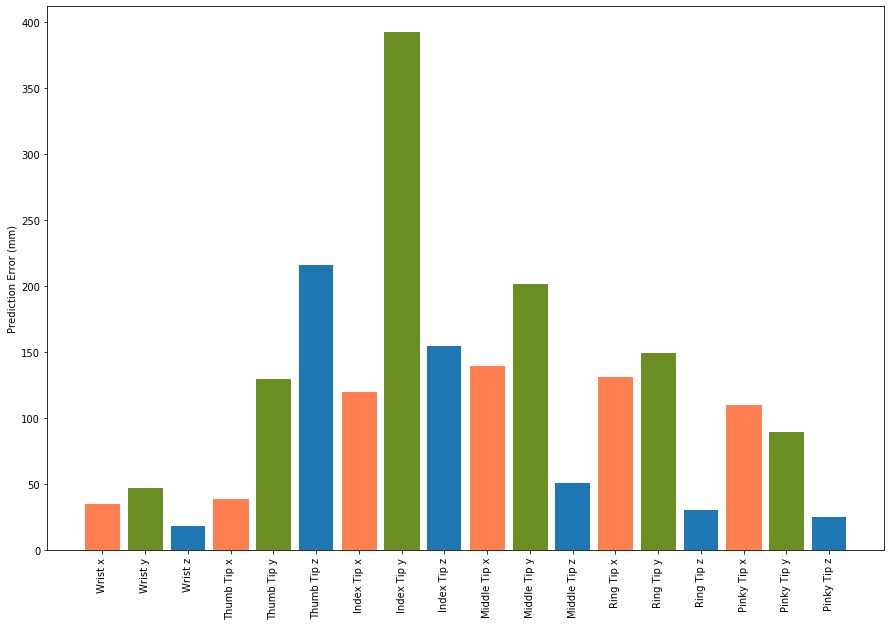

In [35]:
error = labels_tip - preds
sq_error = error * error
avg_error = np.mean(sq_error, axis=0)
plt.figure(figsize=(15, 10))
plt.xticks(rotation=90)
plt.ylabel('Prediction Error (mm)')
bar = plt.bar(df.columns[8:][[0,1,2,12,13,14,24,25,26,36,37,38,48,49,50,60,61,62]], avg_error)
for i in range(0,18,3):
    bar[i].set_color('coral')
    bar[i+1].set_color('olivedrab')
plt.show()